# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [ ]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets

from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [ ]:
# Setting predefined arguments.
args = {
    'epoch_num': 10,      # Number of epochs.
    'lr': 0.0005,         # Learning rate.
    'weight_decay': 1e-5, # L2 penalty.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 50,     # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
    'noise_std': 0.05,    # Artificial gaussian noise standard deviation.
    'noise_prob': 0.05,   # Artificial salt-and-pepper noise probability.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o FashionMNIST

In [ ]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Setting datasets and dataloaders.
train_set = datasets.FashionMNIST(root,
                                  train=True,
                                  download=True,
                                  transform=data_transforms)
test_set = datasets.FashionMNIST(root,
                                 train=False,
                                 download=False,
                                 transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!
Size of training set: 60000 samples
Size of test set: 10000 samples


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Denoising AutoEncoder

Tanto AEs Lineares quanto Convolucionais podem ser adaptados para tarefas diferentes da de redução de dimensionalidade e reconstrução de imagens. Ao adicionar ruído artificial às imagens de entrada antes de passá-las para a forward, por exemplo, é possível treinar um AE para aprender a ignorar esse ruído e reconstruir as imagens originais, efetivamente realizando uma filtragem de ruído treinável. Em suma, é isso que um Denoising AutoEncoder (DAE) faz, como mostra o esquema abaixo.

![Denoising AE](https://www.dropbox.com/s/mekbapirkdvwkhx/Denoising_AE.png?dl=1)

É perceptível que ainda é preciso ter amostras limpas de ruído para treinar esse tipo de método, tornando-o limitado em alguns cenários. Porém, utilizando o conhecimento que se tem sobre as distribuições de ruídos em diferentes tipos de imagens (i.e. [gaussiano](https://en.wikipedia.org/wiki/Additive_white_Gaussian_noise), [salt-and-pepper](https://en.wikipedia.org/wiki/Salt-and-pepper_noise), [ruído quântico](https://www.sciencedirect.com/topics/chemistry/quantum-noise), etc) e realizando algumas suposições sobre a natureza das imagens, é possível construir com pequenas alterações no AE tradicional um removedor de ruído específico para os dados de um certo domínio.

O ruído salt-and-pepper é determinado pixel-a-pixel por uma distribuição de Bernoulli. Ou seja, dados $M$ pixels ${A_{0}, A_{1}, ..., A_{M-1}}$ de uma imagem $A$ e uma probabilidade $p$, cada pixel $A_{i}$ possui uma probabilidade $\frac{p}{2}$ de ser setado para 0 e uma probabilidade $\frac{p}{2}$ de ser setado para 1. No caso do ruído aditivo gaussiano, valores de uma imagem de ruído $B$ (tal que $B_{i} \sim N(0, std)$) amostrada aleatoriamente são somados a todos os pixels da imagem $A$, resultando numa imagem $C = A + B$.

Métodos mais modernos (i.e. [Noise2Noise](https://arxiv.org/pdf/1803.04189.pdf)) conseguem convergir sem a necessidade de dados não afetados pelos ruídos, tornando-os altamente aplicáveis em áreas como [imagens biomédicas](http://www.sprawls.org/ppmi2/NOISE/) ou [sensoriamento remoto](https://en.wikipedia.org/wiki/Synthetic-aperture_radar), as quais normalmente não possuem amostras "limpas" para treinamento de um DAE.

# Atividade Prática: modificando o AE Convolucional para remoção de ruído

1.   Implemente uma função que adicione um ruído do tipo salt-and-pepper em todas as imagens de um batch. Essa função deve receber um tensor de entrada e uma probabilidade $p$ de que cada pixel seja setado para 0 ou para 1, que são os valores mínimos das imagens. Dica: função [*torch.rand_like()*](https://pytorch.org/docs/stable/torch.html#torch.rand_like);
2.   Implemente uma função que adicione um ruído aditivo gaussiano em todas as imagens de um batch. Essa função deve receber um tensor de entrada e um desvio padrão $std$ da distribuição normal que será adicionada a cada pixel. Dica: função [*torch.randn_like()*](https://pytorch.org/docs/stable/torch.html#torch.randn_like);
3.   Modifique a arquitetura do AE Convolucional da aula passada para quadruplicar a quantidade de canais em cada camada convolucional do Encoder e do Decoder. Como nossa preocupação não é mais gerar uma representação compacta dos dados e sim remover ruído, não precisamos mais ser tão econômicos com os canais das convoluções;
4.   Modifique as funções *train()* e *test()* para adicionar ruído usando uma das duas funções a cima na variável *inps* antes de passá-la para a entrada do AE Convolucional;
5.   Varie os valores de args\['noise_std'\] e args\['noise_prob'\] para ver até qual nível de ruído os AEs conseguem reconstruir fidedignamente as imagens originais.


In [ ]:
# TO DO: Adding Salt-and-Pepper with probability p.
def add_salt_and_pepper_noise(tensor, p=0.05):
    
    p_map = torch.rand_like(tensor)
    
    noisy_tensor = tensor.clone()
    noisy_tensor[p_map < (p / 2)] = 0.0
    noisy_tensor[p_map > (1.0 - (p / 2))] = 1.0
    
    return noisy_tensor

In [ ]:
# TO DO: Inserting Additive Gaussian Noise with standard deviation std.
def add_additive_gaussian_noise(tensor, std=0.1):
    
    noise = torch.randn(tensor.size()) * std
    
    noisy_tensor = torch.clamp(tensor + noise, min=0.0, max=1.0)
    
    return noisy_tensor

# Definindo a arquitetura

In [ ]:
# AutoEncoder implementation.
class DenoisingAutoEncoder(nn.Module):
    
    def __init__(self):

        super(DenoisingAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            nn.Conv2d(16, 8, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            nn.Conv2d(8, 1, kernel_size=(3, 3), stride=1, padding=1),
            nn.Sigmoid()
        )
        
        self.initialize_weights()
    
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiating architecture.
net = DenoisingAutoEncoder().to(args['device'])

# Printing architecture.
print(net)


DenoisingAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)


# Definindo o otimizador

O Pytorch possui vários otimizadores prontos no subpacote [optim](https://pytorch.org/docs/stable/optim.html), desde o SGD básico a otimizadores mais complexos e com taxas de aprendizado por parâmetro como o Adagrad, RMSProp e Adam.

In [ ]:
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'])

# Definindo a loss

A loss de um AE tradicional pode ser vista como uma loss de regressão, como o MSE ou a Loss L1.

In [ ]:
criterion = nn.MSELoss().to(args['device'])
# criterion = nn.L1Loss().to(args['device'])

# Criando funções para Treino e Teste

In [ ]:
# Training procedure.
def train(train_loader, net, criterion, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data
        
        # TO DO: Adding gaussian noise.
#         noisy = add_salt_and_pepper_noise(inps, args['noise_prob'])
        noisy = add_additive_gaussian_noise(inps, args['noise_std'])
        
        # TO DO: Casting to cuda variables.
        inps = inps.to(args['device'])
        noisy = noisy.to(args['device'])
        
        # TO DO: Clearing the gradients of optimizer.
        optimizer.zero_grad()

        # TO DO: Forwarding.
        outs = net(noisy)

        # TO DO: Computing loss.
        loss = criterion(outs, inps)

        # TO DO: Computing backpropagation.
        loss.backward()
        
        # TO DO: Taking step in optimizer.
        optimizer.step()
        
        # Updating lists.
        train_loss.append(loss.data.item())
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss.mean(), train_loss.std(), (toc - tic)))
    print('-------------------------------------------------------------------')
    

In [ ]:
# Testing procedure.
def test(test_loader, net, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data
        
        # TO DO: Adding gaussian noise.
#         noisy = add_salt_and_pepper_noise(inps, args['noise_prob'])
        noisy = add_additive_gaussian_noise(inps, args['noise_std'])

        # TO DO: Casting to cuda variables.
        inps = inps.to(args['device'])
        noisy = noisy.to(args['device'])

        # TO DO: Forwarding.
        outs = net(noisy)

        # TO DO: Computing loss.
        loss = criterion(outs, inps)
        
        # Updating lists.
        test_loss.append(loss.data.item())
        
        # Plotting.
        if i == 0 and epoch % args['print_freq'] == 0:
            
            fig, ax = plt.subplots(3, 8, figsize=(24, 9))
        
        if i < 8 and epoch % args['print_freq'] == 0:
            
            ax[0, i].imshow(inps[0, 0].detach().cpu().numpy())
            ax[0, i].set_yticks([])
            ax[0, i].set_xticks([])
            ax[0, i].set_title('Image ' + str(i + 1))
            
            ax[1, i].imshow(noisy[0, 0].detach().cpu().numpy())
            ax[1, i].set_yticks([])
            ax[1, i].set_xticks([])
            ax[1, i].set_title('Noisy ' + str(i + 1))
            
            ax[2, i].imshow(outs[0, 0].detach().cpu().numpy())
            ax[2, i].set_yticks([])
            ax[2, i].set_xticks([])
            ax[2, i].set_title('Reconstructed ' + str(i + 1))
            
        if i == 8 and epoch % args['print_freq'] == 0:
            
            plt.show()
    
    toc = time.time()
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f], [testing time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), (toc - tic)))
    print('-------------------------------------------------------------------')

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [train loss 0.0219 +/- 0.0265], [training time 16.35]
-------------------------------------------------------------------


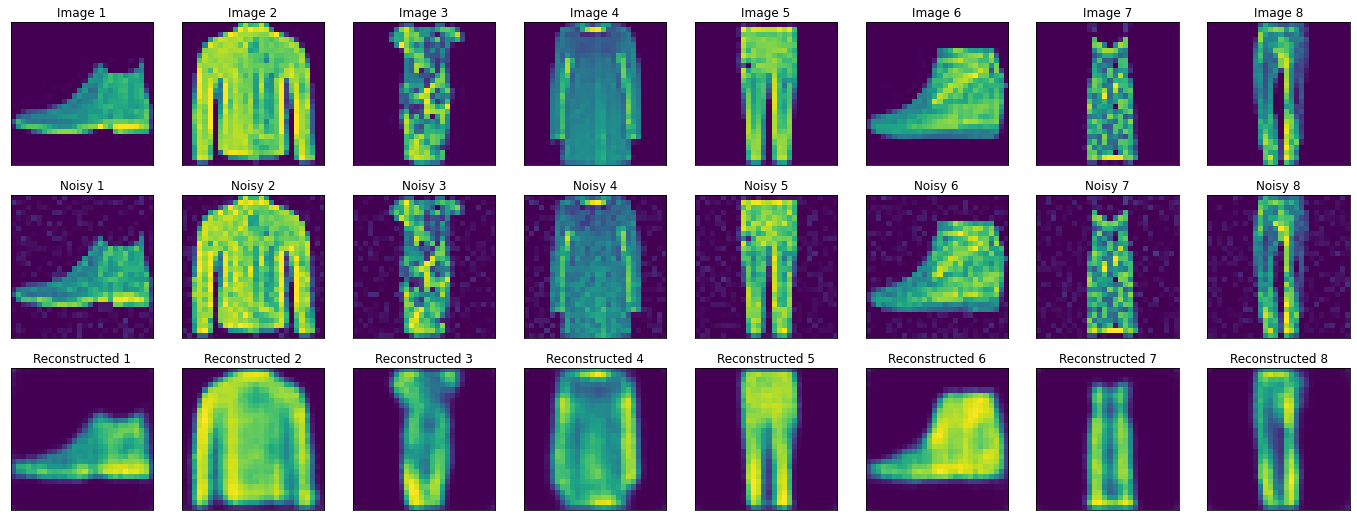

-------------------------------------------------------------------
[epoch 1], [test loss 0.0117 +/- 0.0009], [testing time 2.37]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train loss 0.0103 +/- 0.0010], [training time 16.02]
-------------------------------------------------------------------


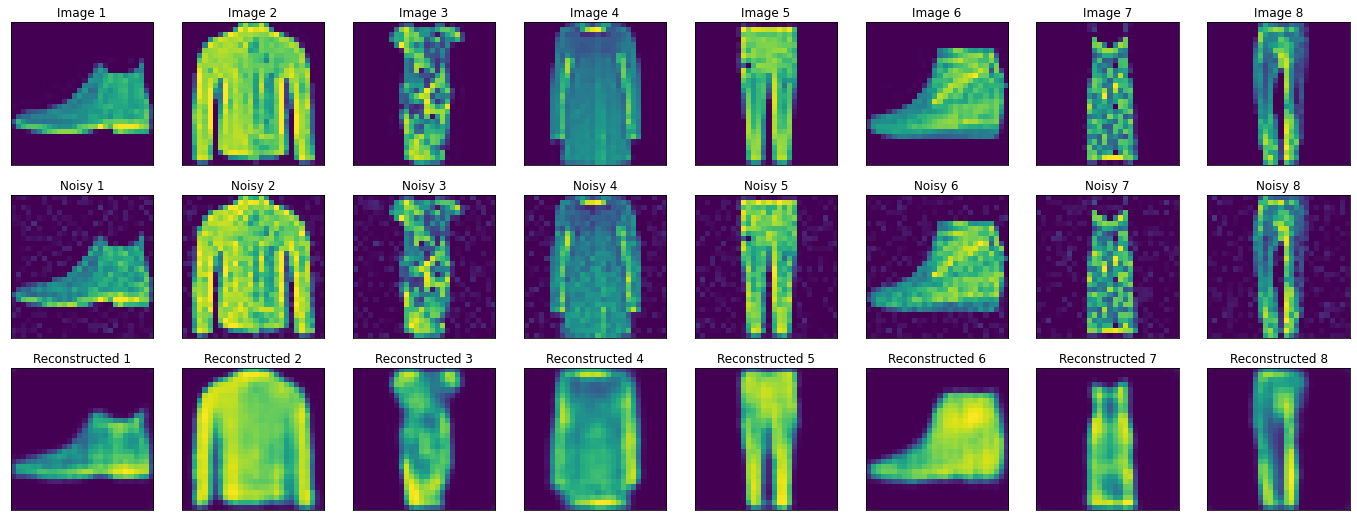

-------------------------------------------------------------------
[epoch 2], [test loss 0.0095 +/- 0.0008], [testing time 2.37]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 3], [train loss 0.0088 +/- 0.0008], [training time 16.12]
-------------------------------------------------------------------


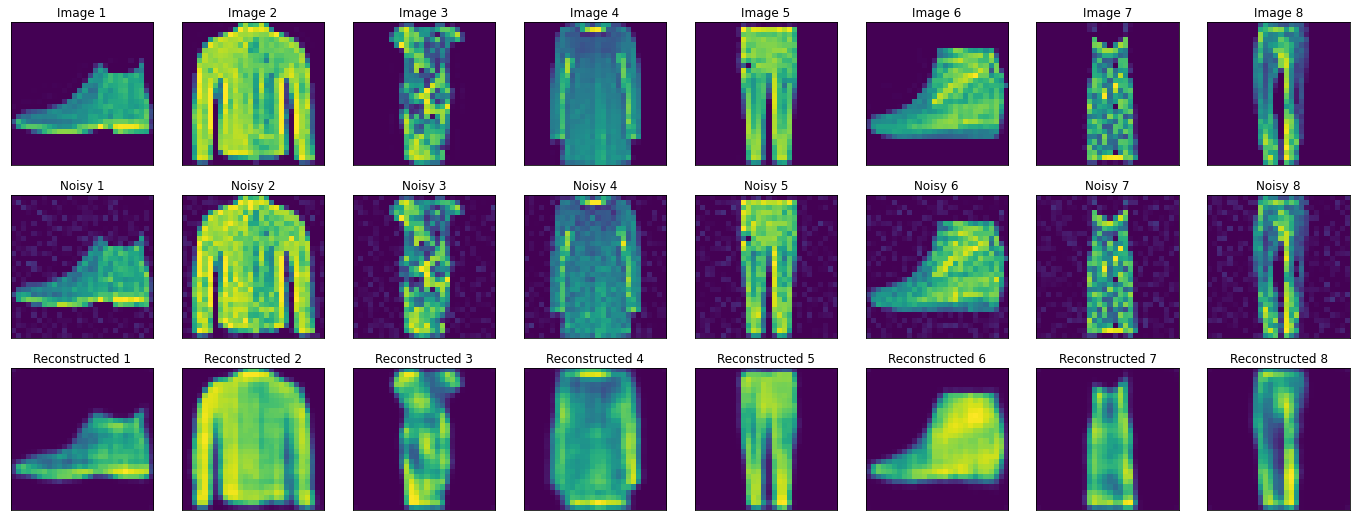

-------------------------------------------------------------------
[epoch 3], [test loss 0.0084 +/- 0.0008], [testing time 2.32]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 4], [train loss 0.0078 +/- 0.0007], [training time 15.90]
-------------------------------------------------------------------


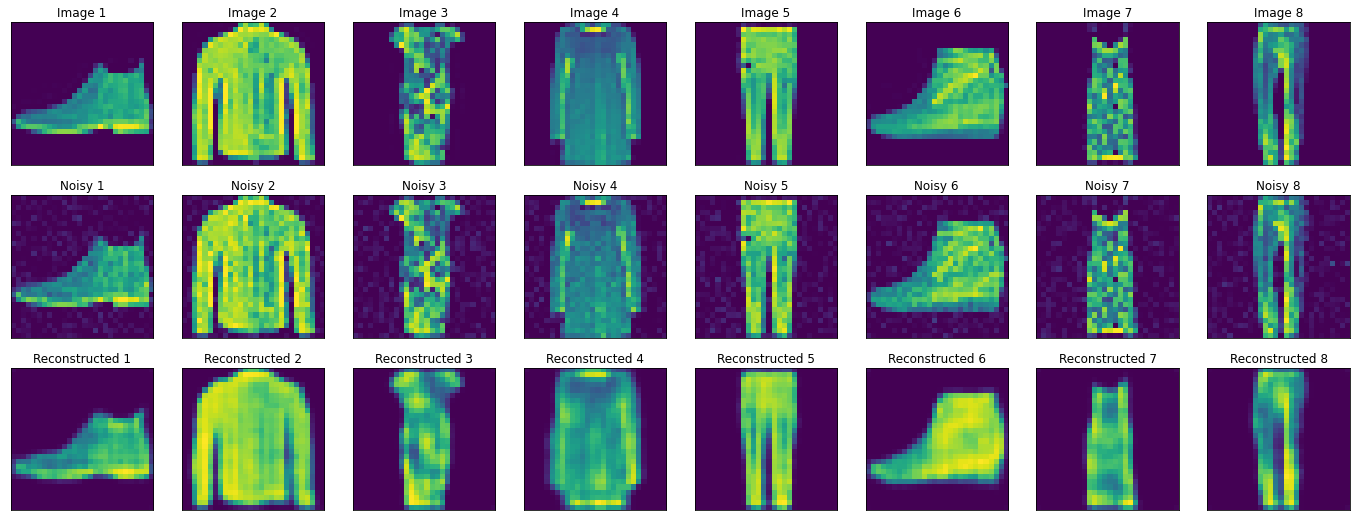

-------------------------------------------------------------------
[epoch 4], [test loss 0.0075 +/- 0.0007], [testing time 2.47]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 5], [train loss 0.0072 +/- 0.0007], [training time 15.88]
-------------------------------------------------------------------


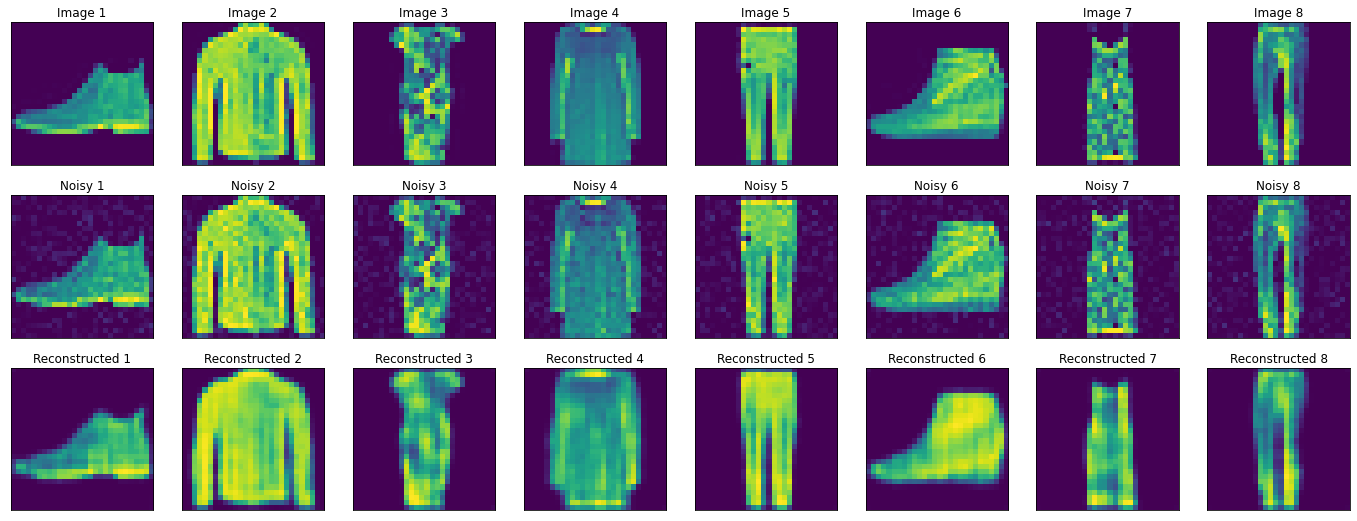

-------------------------------------------------------------------
[epoch 5], [test loss 0.0070 +/- 0.0007], [testing time 2.28]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [train loss 0.0067 +/- 0.0007], [training time 16.01]
-------------------------------------------------------------------


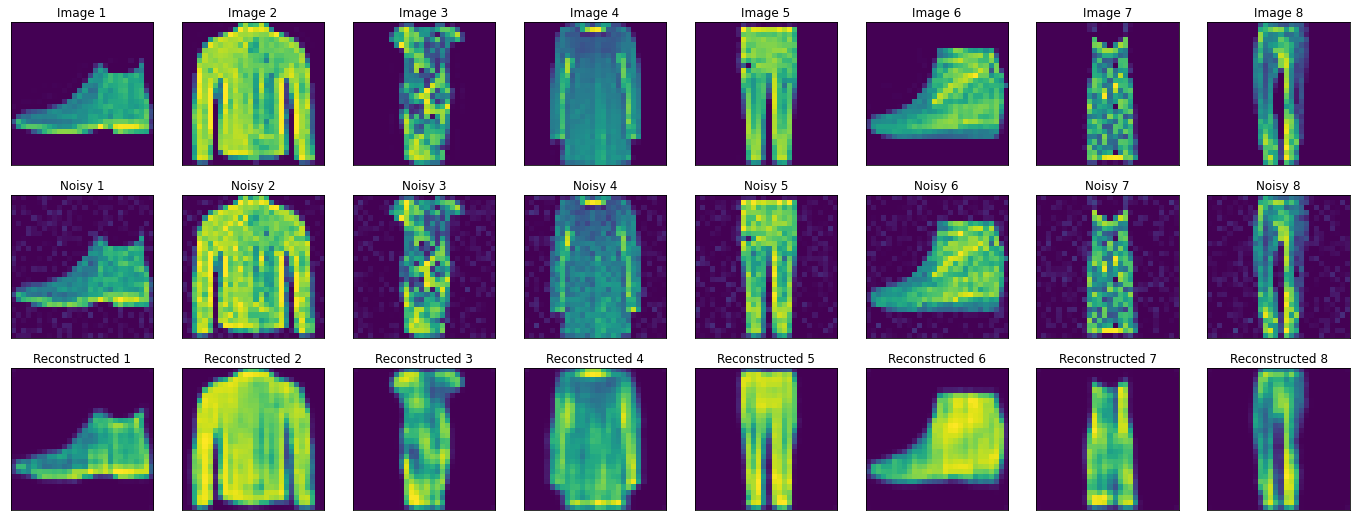

-------------------------------------------------------------------
[epoch 6], [test loss 0.0067 +/- 0.0007], [testing time 2.42]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [train loss 0.0064 +/- 0.0006], [training time 15.90]
-------------------------------------------------------------------


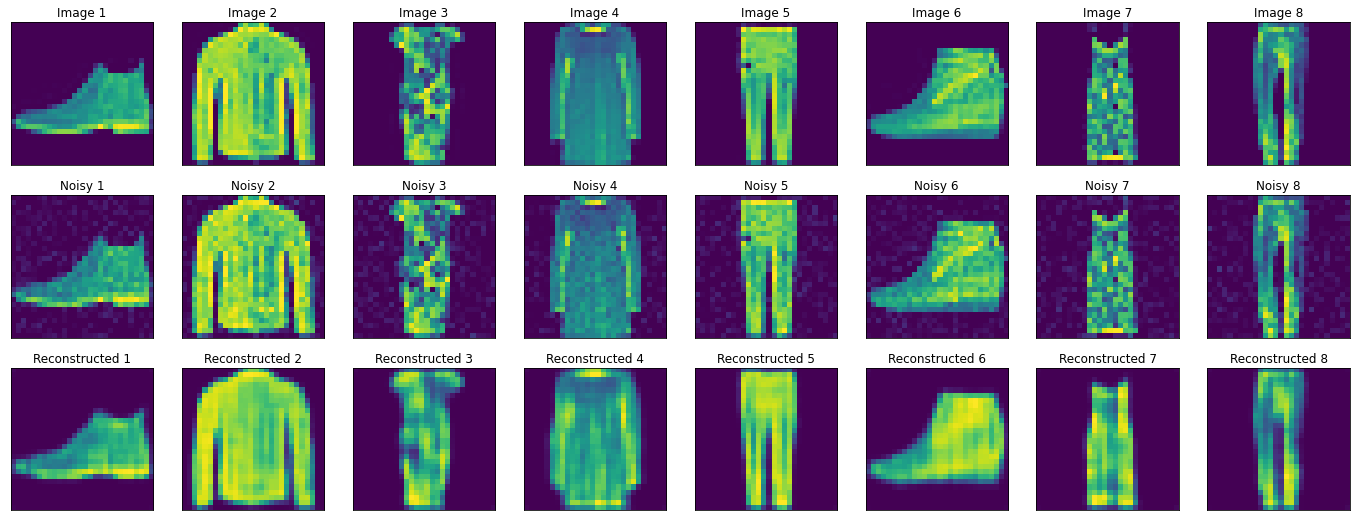

-------------------------------------------------------------------
[epoch 7], [test loss 0.0063 +/- 0.0007], [testing time 2.29]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 8], [train loss 0.0061 +/- 0.0006], [training time 15.81]
-------------------------------------------------------------------


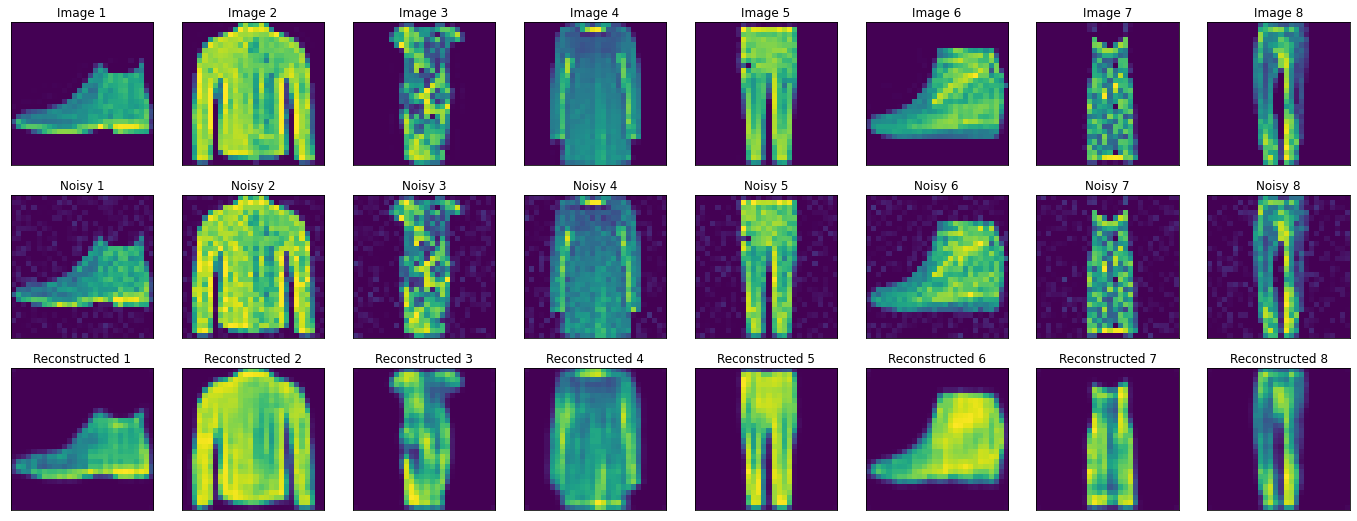

-------------------------------------------------------------------
[epoch 8], [test loss 0.0061 +/- 0.0007], [testing time 2.43]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 9], [train loss 0.0059 +/- 0.0006], [training time 16.00]
-------------------------------------------------------------------


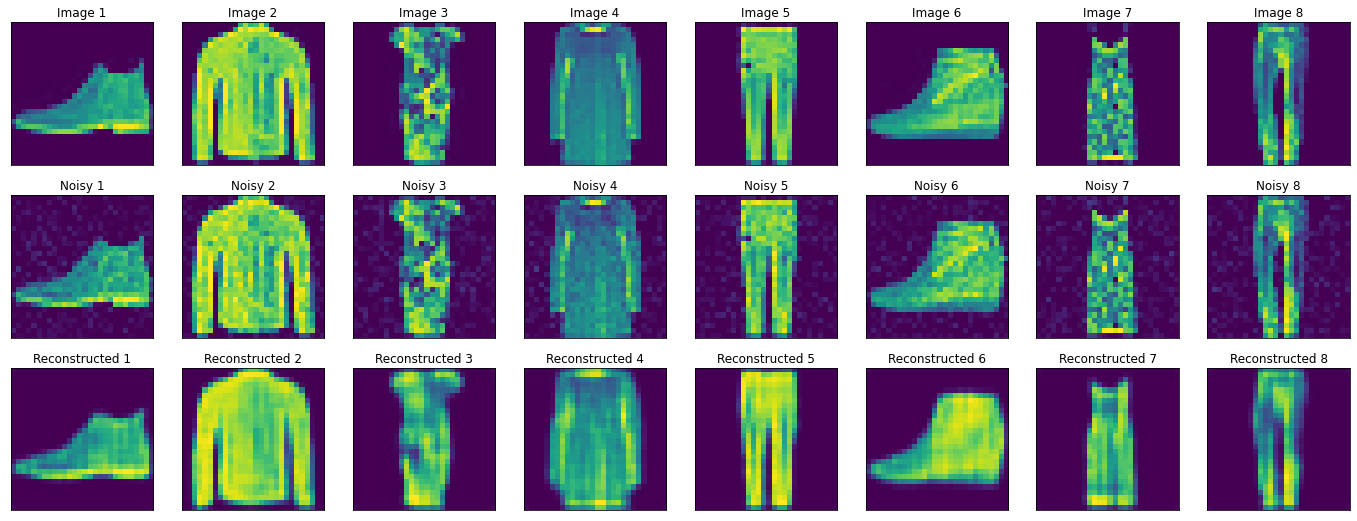

-------------------------------------------------------------------
[epoch 9], [test loss 0.0059 +/- 0.0006], [testing time 2.31]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 10], [train loss 0.0057 +/- 0.0006], [training time 15.87]
-------------------------------------------------------------------


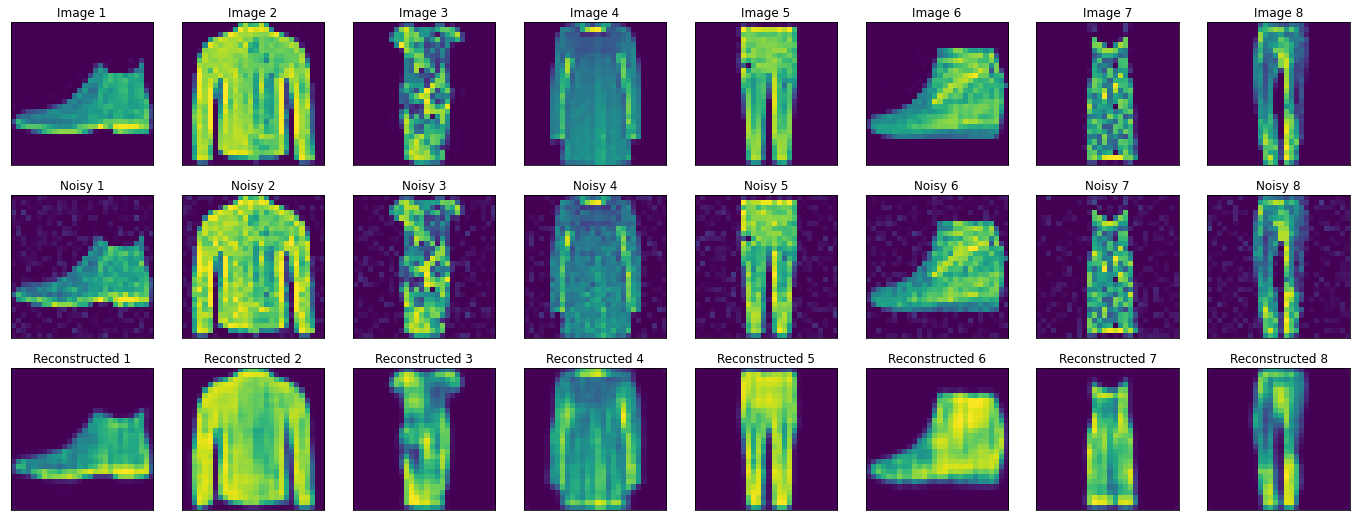

-------------------------------------------------------------------
[epoch 10], [test loss 0.0057 +/- 0.0006], [testing time 2.40]
-------------------------------------------------------------------


In [ ]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, criterion, epoch)